<a href="https://colab.research.google.com/github/aldisstar/Taller-MIT/blob/main/Model_Validation_with_basic_Classification_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Model Validation  with basic Classification Techniques
####Introduction

In the lecture, we talked about:
1. Confusion Matrix
2. Different evaluation metrics: Accuracy, Recall, Precision
3. General Necessity for Validation Procedures

We also discussed:
1. Overfitting/Underfitting
2. Cross Validation Procedures


## Step 0: Import Modules

In [ ]:
# ==============================================
# 0. Module imports
# ==============================================

# data manipulation
import pandas as pd
import numpy as np
import scipy.stats as st
import scipy

# plots
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl

# classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# dimension reduction
from sklearn.decomposition import PCA

# cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection

# parallel processing
from joblib import Parallel, delayed
import multiprocessing

# text mining
import re
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import warnings
warnings.filterwarnings("ignore")

## Step 1: Import Data and Complete Data Splitting

We are using the same Kobe Bryant Shot Selection Dataset that we have been using for the past few days.
As a reminder, the Kaggle Competition Page can be found here (https://www.kaggle.com/competitions/kobe-bryant-shot-selection/discussion/20888) and it contains a record of the shots that Kobe Bryant took throughout his Basketball Career, and which ones he made. The purpose of the dataset is to determine how to predict whether or not Kobe will make a shot.

In [ ]:
# ==========================================
# 1. Data Loading
# ==========================================

# load the data as a pandas dataframe
#Get CSV File from here: https://drive.google.com/file/d/1HTNFCuuwnqpzg5zxPXjIl6Z2pFZ8W7p1/view?usp=share_link

dataset = pd.read_csv('Kobe data.csv')

#
# =============================
# Filter Dataset
# =============================

# Narrow dataset --> 15 features of interest
dataset = dataset.filter(["action_type", "loc_x", "loc_y","shot_distance", "shot_zone_basic", "shot_zone_area", "shot_type",
                                  "period", "minutes_remaining", "seconds_remaining", "playoffs", "season", "game_date","matchup", "shot_made_flag"])

# Remove records where shot_made_flag = null
FullLength = len(dataset)
dataset = dataset.loc[~pd.isnull(dataset['shot_made_flag'])]


In [ ]:
# =============================
# 1.1 Train-val-test split
# Very important for generalizability
# =============================

train, val = train_test_split(dataset, test_size= 0.2, train_size= 0.8, random_state= 234)

## Step 2: Recap \#1 Advanced Models from Yesterday

Lets Start Today's exercise with recalling the logistic regression and gradient boosting models that we built yesterday.

**Exercise 1**:
Do validation of Logistic Regression and Gradient Boosting Model with the given features, and fit on training set


### Define the Features to use, and do feature engineering

In [ ]:
# ==============================================
# Prep for modeling
# ==============================================

#
# =============================
# 2.1 Feature Engineering
# =============================

# convert game_date feature to a datetime object and keep onlt the date part
train['game_date']=pd.to_datetime(train['game_date']).dt.date
val['game_date']=pd.to_datetime(val['game_date']).dt.date

# =============================
# 2.1.1 Variables with missing values
# =============================

# replace missing values with the average of that feature
train["shot_distance"] = train["shot_distance"].fillna(np.mean(train["shot_distance"]))
val["shot_distance"] = val["shot_distance"].fillna(np.mean(val["shot_distance"]))

# =============================
# 2.1.2 Categorical variables
# =============================

# dummy variables for shot zones (one hot encoding)
shot_zones_train = pd.get_dummies(train["shot_zone_basic"], prefix= "shot_zone")
shot_zones_val = pd.get_dummies(val["shot_zone_basic"], prefix= "shot_zone")

# combine dummy variable columns with the rest of the dataset
train = train.join(shot_zones_train)
val = val.join(shot_zones_train)


### Exercise #1
For the purposes of recalling material from yesterday, build Logistic Regression and Gradient Boosting models for the features we have chosen for the dataset.

What do you observe in the performance? What does it signify to you about the features?

In [ ]:
# ==========================================
# 2. Modeling
# ==========================================

# =============================
# 2.1 Baseline model
#   Logistic regression
# =============================

# use only numeric variables without any missing values
feat = ["minutes_remaining", "loc_x", "loc_y", "seconds_remaining"]
train_feats = train[feat]
val_feats = val[feat]
label = "shot_made_flag"

#create logistic regression model and fit on training data, then predict on validation data
logReg = LogisticRegression()
logReg.fit(train_feats, train["shot_made_flag"])

# predict on validation data
logReg_val = logReg.predict_proba(val_feats)[:,1]

#Lets Check on its performance (logReg_val.values = the values of the prediction on validation data, substitute with name used)
print("Baseline logistic performance: " + str(np.round(roc_auc_score(val[label], logReg_val), 5)))


# =============================
# 2.1 Baseline model
#   Gradient Boosting
# =============================
# simple gbm
gbm = GradientBoostingClassifier()

gbm.fit(train_feats, train[label])

# predict on validation data
gbm_val = gbm.predict_proba(val_feats)[:,1]
print(" -- -- -- ")

# auc score
print("Baselin GBM performance: " + str(np.round(roc_auc_score(val[label], gbm_val), 5)))


Baseline logistic performance: 0.58856
 -- -- -- 
Baselin GBM performance: 0.61863


## Step 3: Explore evaluation metrics: The different measures using which you can evaluate your models.  

After doing the usual feature engineering, selection, implementing a model and getting output in terms of a probability or class, the next step is to find out how *effective* the model is. This is done using different performance metrics, that are used to evaluate different machine learning models.

From the example in Exercise 1, you can observe that different models are superior in performance using different features. Above, the evaluation metric *AUC* helped us in determing the model to select.

In the next section, we are going to learn about different ways to evaluate our models.

**Exercise 2**:
Generate confusion matrix and write and explain TP, FP, TN, FP for our models.

**Exercise 3**:
Do the same for Gradient Boosting

### 3.1 Confusion Matrix

A confusion matrix is a table with 4 different combinations of predicted and actual values. Here is a confusion matrix in picture form. On the left, we see a confusion matrix and on the right we see an explanation of TP, FP, FN, TN.  

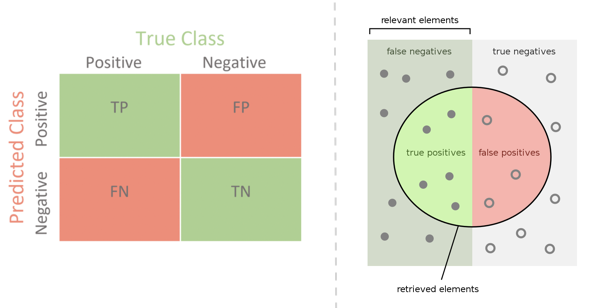

Let's understand these concepts in terms of prediction of Pneumonia, a binary classification task of 0 (**No Pneumonia** i.e. Negative class) vs 1 (**Present Pneumonia** i.e. Postive Class). Suppose you built a machine learning model that is able to predict whether a patient's chest X ray image indicated Pneumonia.

* TP = True Positive, *Model predicted 1 and the actual value is 1*
* FP = False Positive, *Model predicted 1 but the actual value is 0*
* FN = False Negative, *Model predicted 0 but the actual value is 1*
* TN = True Negative, *Model predicted 0 and the actual value is 0*

#### **Exercise #2**

Let's generate a confusion matrix for our Logistic Regression model built on tf-idf and combined features.

Instead of calculating predicted probabilities from logistic regression, calculate the final predicted values. Observe the dimensionality differences of predicted probabilities vs the final predictions. What is the difference between the two? Based on what we learned yesterday about logistic regression, can you explain how we go from predicted probabilities to final predictions?

In [ ]:
def logReg_confusion_matrix(train_feats, val_feats, train, val):
  logReg = LogisticRegression()
  logReg.fit(train_feats, train[label]) # fit logistic regression

  # calculate predictions and true labels from a logistic regression model
  # Save each as a Pandas Series with the name = "Predicted Class" and "True Class"

  logReg_predictions = pd.Series(logReg.predict(val_feats), name = 'Predicted Class')
  logReg_truelabel = pd.Series(val[label].values, name='True Class')

  # generating our confusion matrix using pd.crosstab
  df_confusion = pd.crosstab(logReg_predictions, logReg_truelabel, margins=True)
  return df_confusion

df_confusion_logReg = logReg_confusion_matrix(train_feats, val_feats, train, val)
print(df_confusion_logReg)

True Class        0.0   1.0   All
Predicted Class                  
0.0              2066  1395  3461
1.0               781   898  1679
All              2847  2293  5140


#### **Exercise #3**
Can you fill in the values and explanations for TP, FP, FN, TN in the context of the `df_confusion_logReg_idfdtmfeats` confusion matrix above?

TP = 898; The shot was successful, and it was predicted to be successful.

FP = 781; The shot was not successful, but it was predicted to be successful.

FN = 2066; The shot was successful, and it was not predicted to be successful.

TN = 1395; The show was not successful, and it was not predicted to be successful.


#### **Exercise #4**
Repeat the above process for Gradient Boosting on both `train_feat_combine` and `train_idf_dtm` features
1. Generate the predicted classes
2. Generate the confusion matrix using true class and predicted class
3. Fill in the numerical values for TP, FP, FN, TN in the context of the generated confusion matrix

In [ ]:

def gbm_confusion_matrix(train_feats, val_feats, train, val):
  gbm = GradientBoostingClassifier()
  gbm.fit(train_feats, train[label])
  gbm_predictions = pd.Series(gbm.predict(val_feats), name = 'Predicted Class')
  gbm_truelabel = pd.Series(val[label].values, name='True Class')

  df_confusion_gbm = pd.crosstab(gbm_predictions, gbm_truelabel, margins=True)
  return df_confusion_gbm

df_confusion_gbm = gbm_confusion_matrix(train_feats, val_feats, train, val)
print(df_confusion_gbm)

True Class        0.0   1.0   All
Predicted Class                  
0.0              2413  1555  3968
1.0               434   738  1172
All              2847  2293  5140


(Optional) Finally, compare the confusion matrix of Gradient Boosting vs Logistic Regression on both `train_feat_combine` and `train_idf_dtm` each.

Thus, you are going to compare the numbers for gradient boosting with `train_feat_combine` vs logistic regression with `train_feat_combine`. Additionally, you will compare the numbers for gradient boosting with `train_idf_dtm` vs logistic regression with `train_idf_dtm`. Which model do you find superior in each case and why? Which has a higher False Positive vs False Negative rate?

### 3.2. Balancing the False Positives and False Negatives: Accuracy, Precision, Recall metrics

There will be errors associated with models that are used for predicting the true class of the target variable. This will result in *False Positives* and *False Negatives* (i.e. all incorrect predictions).

Depending on the problem you are trying to solve, you may care about different errors to minimize.

* **False Negatives**: We minimize FN s in cases where we don't want to **miss** correctly classifying any positives (i.e. where the actual label is 1). This becomes important in healthcare settings, for eg, with predicting Pneumonia (0: No pneumonia, 1: Present pneumonia). You want to correctly catch maximum cases of patients with actual Pneumonia. Out of 100 patients, if only 5 of them have pneumonia and your model randomly predicts everyone as *not having pneumonia*, it is a very **bad** model. This model has a **High False Negative (FN)** rate. Such a model will have 95% correctness by sheer numbers (aka Accuracy), yet is a bad model for our setting. It's also not ideal that accuracy is scaling by the total number of elements in this case, as we care about the total number of patients with actual pneumonia.

* **False Positives**: We minimize FP in cases where we cannot afford to **incorrectly** classify any positives (i.e. where the actual label is 1). This is important for a common task like Spam detection (0: Email is not spam, 1: Email is spam). For eg, you are waiting to hear back from a recruiter for a job and your model incorrectly marks the recruiters email as Spam (a case of **False Positive**). This Spam detection model is considered very bad if it has a **High False Positive (FP)** rate.

In each of the two models, it does not matter if the other metric is high or low. For the Pneumonia detection model, *High FP* do not matter as a clinician can just discard those samples (the worst it does is waste their time rather than cause them to miss diagnosing a patienet). For the Spam detection model, *High FN* do not matter as spam emails in our main inbox (classified as not spam) will simply need to be manually deleted by us (at most they will waste our time rather than cause us to miss an important recruiter email).

Different metrics below will help us prioritize different measures out of False Positive and False Negative.

#### 3.2.1 Accuracy
Defined as the total number of correct predictions made by the model over all predictions.

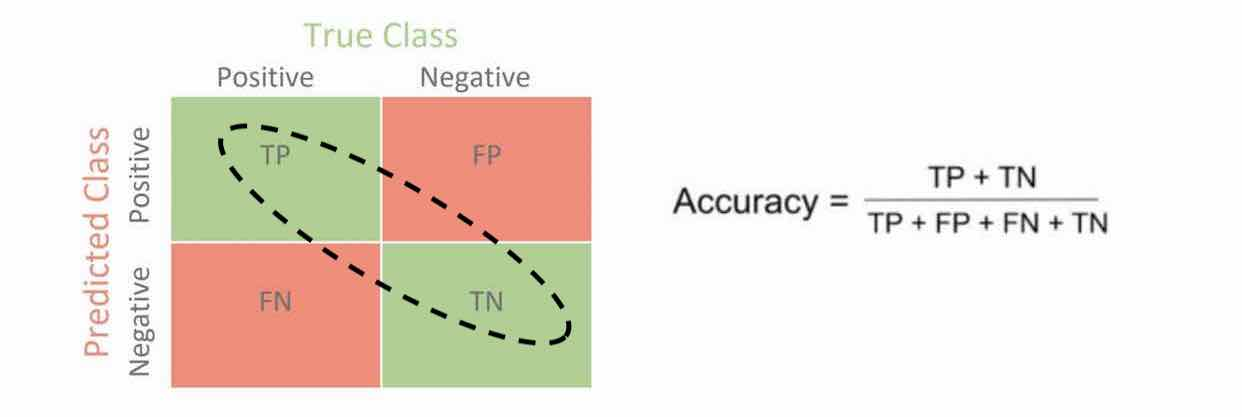

##### **Exercise \#5**
Fill in the elements to feed to `sklearn.accuracy_score` for calculation. We are focusing only on the logistic regression algorithm here.

In [ ]:
def logReg_accuracy(train_feats, val_feats, train, val):
  logReg = LogisticRegression()
  logReg.fit(train_feats, train[label]) # fit logistic regression

  # fill the logistic regression predictions from exercise # 2

  logReg_predictions = pd.Series(logReg.predict(val_feats), name = 'Predicted Class')
  logReg_truelabel = pd.Series(val[label].values, name='True Class')


  #enter the parameters to provide to accuracy_score
  acc = accuracy_score(logReg_truelabel, logReg_predictions)
  return acc

acc_logReg = logReg_accuracy(train_feats, val_feats, train, val)

In [ ]:
print("Logistic regression accuracy", round(acc_logReg, 3))

Logistic regression accuracy 0.577


#### 3.2.2 Precision

Precision is a measure that tells us what proportion of patients we diagnosed as having pneumonia, actually had pneumonia.

e.g. In our example of 100 people with 5 having pneumonia. If a bad model predicts every case as **Pneumonia**, recall that accuracy was 95%. But, precision is calculated as 5/100 (TP + FP = 100, TP = 5) i.e. 5%. Hence, precision is a better measure to help with our specific healthcare setting. Note that this isn't a generalizable statement for all healthcare settings

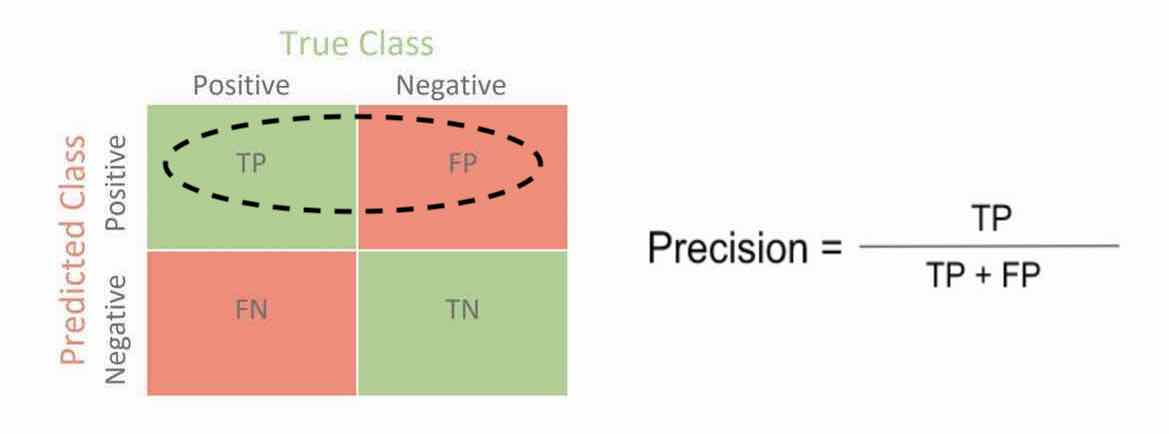

##### **Exercise #6**
Calculate the `sklearn.metrics.precision_score` for logistic regression on `train_feats`, along with the respective features on the validation set.

In [ ]:

def logReg_precision(train_feats, val_feats, train, val):
  logReg = LogisticRegression()
  logReg.fit(train_feats, train[label])

  logReg_predictions = pd.Series(logReg.predict(val_feats), name = 'Predicted Class')
  logReg_truelabel = pd.Series(val[label].values, name='True Class')

  prec = precision_score(logReg_truelabel, logReg_predictions)
  return prec

prec_logReg = logReg_precision(train_feats, val_feats, train, val)


In [ ]:
print("Logistic regression precision", round(prec_logReg, 3))

Logistic regression precision 0.535


#### 3.2.3 Recall

Recall is a measure that tells us what proportion of patients that actually had pneumonia was diagnosed by the algorithm as having pneumonia.

Lets go back to our example of pneumonia prediction, with 100 people and 5 peple actually having pneumonia and model predicting every case as having pneumonia (label 1). In this case, TP + FN = 5 and TP = 5. Hence, recall is 100%.

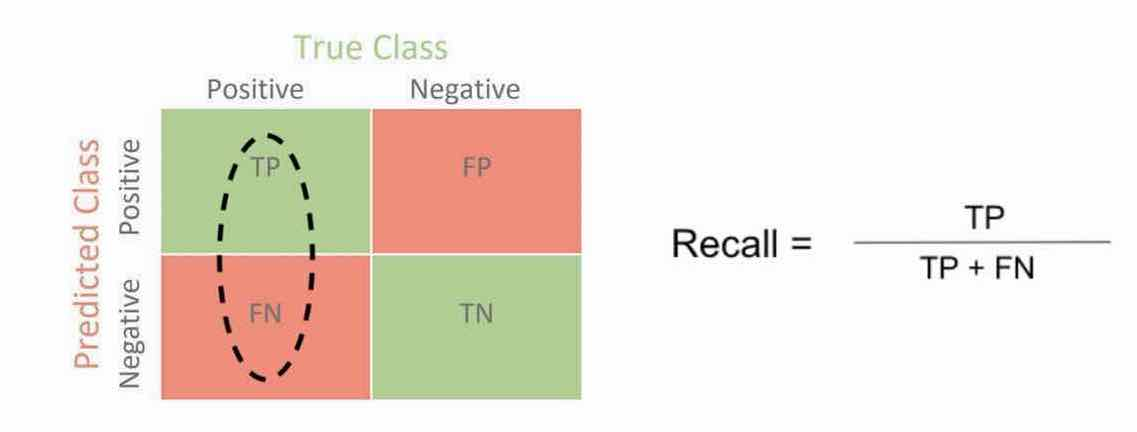

##### Exercise #7

Calculate the `sklearn.metrics.recall_score` for logistic regression over `train_feats`, along with the respective features on the validation set.

In [ ]:

def logReg_recall(train_feats, val_feats, train, val):
  logReg = LogisticRegression()
  logReg.fit(train_feats, train[label])

  logReg_predictions = pd.Series(logReg.predict(val_feats), name = 'Predicted Class')
  logReg_truelabel = pd.Series(val[label].values, name = 'True Class')

  recall = recall_score(logReg_truelabel, logReg_predictions)
  return recall

recall_logReg = logReg_recall(train_feats, val_feats, train, val)

In [ ]:
print("Logistic regression recall", round(recall_logReg, 3))

Logistic regression recall 0.392


#### Exercise #8: Repeat for Gradient Boosted Model

Repeat the above steps to calculate the accuracy, precision, and recall of the gradient boosted model (the code should look extremely similar to what you have above!)

Can you compare the Precision vs Recall vs Accuracy of the Logistic Regression and Gradient Boosted model? What does it tell you about the False Positive vs False Negative of the two models? Can you imagine situations where a model with low AUC score (from yesterday) but higher values in other metrics could be more useful?

You may want to think about this question deeply, by exploring the different metric values such as Precision vs Recall vs Accuracy vs AUC from before.

Note: We won't be going in depth about the explanation of AUC in lecture, but you are welcome to read more about it in your own time.

In [ ]:
# function to calculate accuracy of Gradient Boosted Model
def gbm_accuracy(train_feats, val_feats, train, val):
  gbm = GradientBoostingClassifier()
  gbm.fit(train_feats, train[label])

  gbm_predictions = pd.Series(gbm.predict(val_feats), name = 'Predicted Class')
  gbm_truelabel = pd.Series(val[label].values, name='True Class')

  # enter the parameters to provide to accuracy_score
  acc = accuracy_score(gbm_truelabel, gbm_predictions)
  return acc

# function to calculate precision of Gradient Boosted Model
def gbm_precision(train_feats, val_feats, train, val):
  gbm = GradientBoostingClassifier()
  gbm.fit(train_feats, train[label])

  gbm_predictions = pd.Series(gbm.predict(val_feats), name = 'Predicted Class')
  gbm_truelabel = pd.Series(val[label].values, name='True Class')

  prec = precision_score(gbm_truelabel, gbm_predictions)
  return prec

# function to calculate recall of Gradient Boosted Model
def gbm_recall(train_feats, val_feats, train, val):
  gbm = GradientBoostingClassifier()
  gbm.fit(train_feats, train[label])

  gbm_predictions = pd.Series(gbm.predict(val_feats), name = 'Predicted Class')
  gbm_truelabel = pd.Series(val[label].values, name='True Class')

  recall = recall_score(gbm_truelabel, gbm_predictions)
  return recall

# calculate GBM accuracy
acc_gbm = gbm_accuracy(train_feats, val_feats, train, val)
print("Gradient Boosted accuracy", round(acc_gbm, 3))

# calculate GBM precision
prec_gbm = gbm_precision(train_feats, val_feats, train, val)
print("Gradient Boosted precision", round(prec_gbm, 3))

# calculate GBM recall
recall_gbm = gbm_recall(train_feats, val_feats, train, val)
print("Gradient Boosted recall", round(recall_gbm, 3))

Gradient Boosted accuracy 0.613
Gradient Boosted precision 0.63
Gradient Boosted recall 0.322


#### Exercise #8.1 [IF YOU HAVE TIME] Beyond Precision, Recall and Accuracy

There are certainly other metrics to optimize for different settings, based on whether we care about false positives, false negatives or a combination of both. We also have other metrics, such as Specificity and F1 score. **Specificity** is defined as the opposite of Recall, and **F1 score** is defined as the harmonic mean of Precision and Recall. Finally, we have the AUC-ROC curve and score, which is heavily used in the medical settings.

We encourage you to read about these different metrics in detail from [this medium article](https://medium.com/@MohammedS/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b) and [this one](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5). Can you think about which settings different metrics could be useful for?

If you have more time, you can read about the libraries of F1 score and AUC score in python (find them yourself this time!) and implement the score for the same logistic regression model with 2 features as we have been exploring in this notebook.

# Step 4: Towards Generalizability

Generalizability is important for building a *useful model*. We use val and test sets to prevent overfitting to the different combinations of features and parameters we try with our model.  

4.1 (Optional) Long explanation

So far, we have been using a training, validation and test set for model development and validation. On *Day 2, we only started with train and test set*. On *Day 3, we introduced the validation set*. In the paradigm of a machine learning model, we use the train features and true labels to train the model. Then, we use the validation/test features to obtain the predicted labels. Finally, we compare the predicted labels with the true labels to evaluate the model. In Step 4, we saw different measures that can be used to evaluate ML models.

In mechanics, the same process is followed for validation and test sets: provide features, obtain predictions and evaluate the model. So why do we need both validation and test sets? And is there more?

Our *objective* is to obtain the best performing machine learning model for our task, e.g. basketball shot classification.

This is where **G E N E R A L I Z A B I L I T Y** comes in.

Generalizability is perhaps one of the most important concepts in ML. Remember, why are we building ML models in the first place? We want to build a *useful model*.

The stochastic nature of these models help us in automatically learning a fit for our training data. This learned model is then used to make predictions on our test set. For real world usefulness of this model, this model needs to be able to generalize to new, unseen examples beyond the test set. As you saw yesterday, there's many different aspects to test for obtaining the best possible machine learning model. We explored logistic regression, gradient boosting, tf-idf, PCA, learning rate, regularization, random forest, decision trees, ensemble learning etc.

If we keep using the same test set to optimize for our model performance using various changes to it, we run the risk of **Overfitting**. In order to avoid overfitting, we divide our data into train, validation and test. So that we will explore all the different features using validation set, but ultimately assess the performance using the test set. Some Kaggle competitions don't even share their test sets publicly, they are only for internal use for generating the leaderboard.

Today, we will learn different ways to divide up the data to get away from this problem of overfitting and obtain the best generalizable model.

## 4.2 Cross validation

Previously, we were dividing our dataset into train, val and test. Now, we are going to divide our dataset even further for generalizability purposes.

There are many different types of cross validation, but we are only going to explore k-fold cross validation today. In k-fold cross validation, the original dataset is equally partitioned into k subparts or folds. Out of the k folds, one group is selected as validation data and the remaining (k-1) groups are selected as training data. The process is repeated k times until each group is treated as validation and remaining as training data.

An example of 5 fold cross validation is below
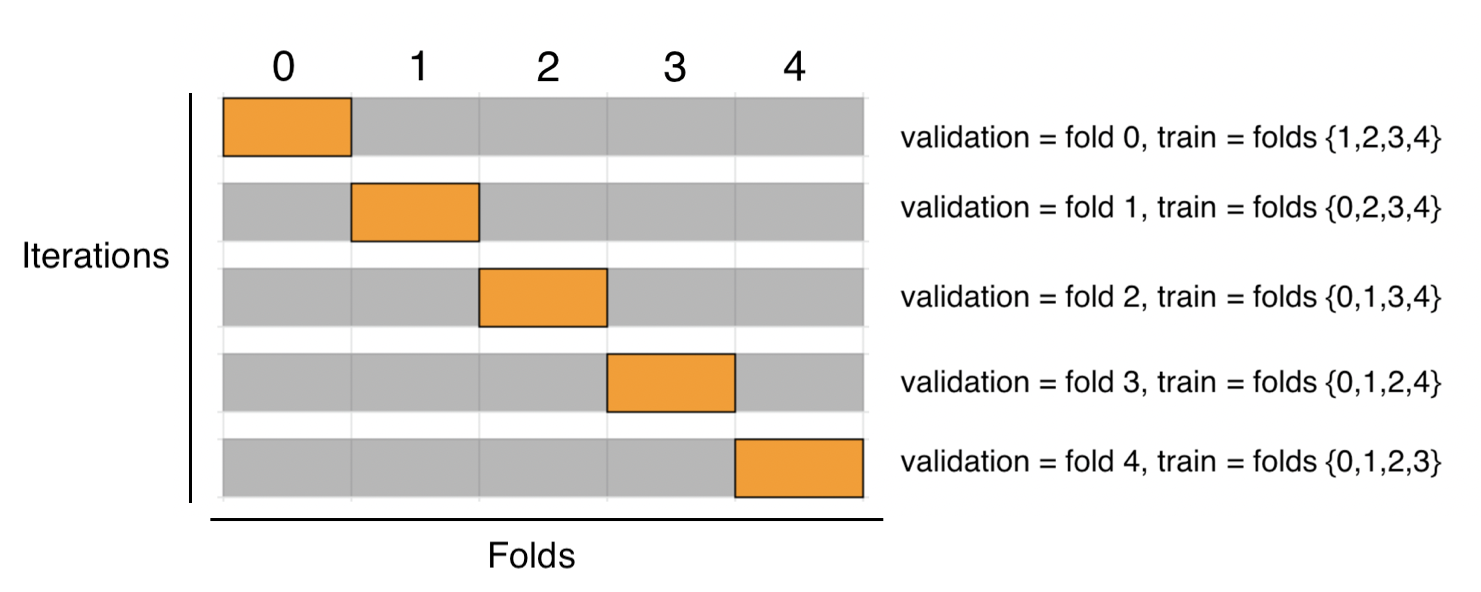



### **Exercise #9**
If we have 5 iterations in 5 fold cross validation, how many different evaluation scores will we have in the end?

5x5 = 25 different iterations

### Exercise #10
Let's explore 5 fold cross validation on our shot selection dataset, for the logistic regression model.

Can you take a look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) and display the three scores: Accuracy, Precision and Recall in addition to roc_auc?


In [ ]:
# =============================
# 5.2 Cross-val Logistic Regression
# =============================

# Calculating cross validation score for the combined features

def logReg_cv_score(data_feats, data_labels, scoring):
  """
  Function calculates the cross validation scores using sklearn.model_selection.cross_val_score
  Note: cross_val_score will take care of fitting, splitting and scoring for you

  data_feats: features of dataset
  data_labels: labels of dataset:
  scoring: evaluation metric (i.e. accuracy, precision, etc.)
  """

  logReg = LogisticRegression()

  #use cross_val_score to calculate scores using 5 folds
  scores = cross_val_score(estimator = logReg,
                           X = data_feats,
                           y = data_labels,
                           cv = 5,
                           scoring= scoring)
  return scores

# look at the documentation of cross_val_score, and change the scoring parameter
scoring = ['accuracy', 'precision', 'recall', 'roc_auc']

# Combine the original train and val features, as cross val operation will take care of the splitting for us
data_feat_combine = pd.concat([train_feats, val_feats])
data_labels = pd.concat([train[label], val[label]])

for score in scoring:
  print(score)
  cv_logReg_combinedfeats = logReg_cv_score(data_feat_combine, data_labels, score)
  print('Cross Validated Scores', cv_logReg_combinedfeats)
  print('CV mean + std: %.4f \t %.4f'% (np.mean(cv_logReg_combinedfeats), np.std(cv_logReg_combinedfeats)))
  print('---------------------')

accuracy
Cross Validated Scores [0.5848249  0.58521401 0.58143608 0.57462541 0.57657132]
CV mean + std: 0.5805 	 0.0043
---------------------
precision
Cross Validated Scores [0.54751943 0.54794521 0.54142357 0.5285638  0.53484217]
CV mean + std: 0.5401 	 0.0075
---------------------
recall
Cross Validated Scores [0.39947667 0.40122111 0.40470999 0.4317488  0.39162669]
CV mean + std: 0.4058 	 0.0137
---------------------
roc_auc
Cross Validated Scores [0.59267152 0.58905013 0.57713483 0.58103515 0.58851284]
CV mean + std: 0.5857 	 0.0057
---------------------


In [ ]:
print('Cross Validated Scores', cv_logReg_combinedfeats)
print('CV mean + std: %.4f \t %.4f'% (np.mean(cv_logReg_combinedfeats), np.std(cv_logReg_combinedfeats)))

Cross Validated Scores [0.59679785 0.58683066 0.57813753 0.58027876 0.5931586 ]
CV mean + std: 0.5870 	 0.0072


In [ ]:
# ANSWER to exercise
# just keep changing scoring parameter above to precision, recall and accuracy

If you recall from before when we evaluated the Logistic Regression values, we were getting 0.66 as our AUC. These two scores are fairly close. However, in some cases, the contrast between the val performance and CV performance can be more stark. In all cases, it is always better to perform cross validation as the validation set could contain split bias. However, if you have limited computation, it is ok to use train, val, test sets to do model selection.

Further Reading And References:

[1] https://scikit-learn.org/stable/modules/cross_validation.html

[2] https://scikit-learn.org/stable/modules/grid_search.html#multimetric-grid-search

[3] https://towardsdatascience.com/understanding-8-types-of-cross-validation-80c935a4976d

[4] https://medium.com/@MohammedS/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b

[5] https://towardsdatascience.com/overfitting-vs-underfitting-a-complete-example-d05dd7e19765

[6] https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62

[7] https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826

[8] https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative

[9] https://en.wikipedia.org/wiki/Precision_and_recall

[10] https://towardsdatascience.com/overfitting-vs-underfitting-a-complete-example-d05dd7e19765
